In [ ]:

!pip install git+https://github.com/yashpatel2010/mpdistil.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 1. Custom Training Configuration

In [ ]:
from mpdistil import MPDistil, TrainingConfig, load_superglue_dataset

# Create custom config
config = TrainingConfig(
    # Phase 1: Teacher
    teacher_epochs=15,
    teacher_lr=1e-5,

    # Phase 2: Student PKD
    student_epochs=15,
    student_lr=5e-5,
    alpha=0.7,
    beta=50.0,
    temperature=3.0,

    # Phase 3: Meta-Teacher
    meta_lr=5e-4,
    use_competitive_loss=True,

    # Phase 4: Curriculum
    num_episodes=300,
    reward_type='real',
    gamma=0.95,

    # System
    batch_size=16,
    seed=12345,
    verbose=True,

    # Checkpointing
    output_dir='./advanced_outputs',
    save_checkpoints=True
)

print(config.to_dict())

{'teacher_epochs': 15, 'teacher_lr': 1e-05, 'skip_teacher_training': False, 'student_epochs': 15, 'student_lr': 5e-05, 'alpha': 0.7, 'beta': 50.0, 'temperature': 3.0, 'meta_lr': 0.0005, 'use_competitive_loss': True, 'num_episodes': 300, 'reward_type': 'real', 'gamma': 0.95, 'batch_size': 16, 'max_grad_norm': 1.0, 'weight_decay': 0.01, 'warmup_steps': 0, 'seed': 12345, 'device': 'auto', 'fp16': False, 'fp16_opt_level': 'O1', 'wandb_logging': False, 'wandb_project': 'mpdistil', 'verbose': True, 'output_dir': './advanced_outputs', 'save_checkpoints': True, 'resume_from_checkpoint': None}


## 2. Multi-Task Curriculum Learning

In [ ]:
# Load main task
cb_loaders, cb_labels = load_superglue_dataset('CB', batch_size=16)

# Load auxiliary tasks for curriculum learning
print("Loading auxiliary tasks...")
rte_loaders, _ = load_superglue_dataset('RTE', batch_size=16)
boolq_loaders, _ = load_superglue_dataset('BoolQ', batch_size=16)
copa_loaders, _ = load_superglue_dataset('COPA', batch_size=16)

# Create model
model = MPDistil(
    task_name='CB',
    num_labels=cb_labels,
    student_layers=6
)

# Train with curriculum learning on multiple tasks
history = model.fit(
    train_loader=cb_loaders['train'],
    val_loader=cb_loaders['val'],
    meta_loaders={
        'RTE': rte_loaders['val'],
        'BoolQ': boolq_loaders['val'],
        'COPA': copa_loaders['val']
    },
    config=config
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

cb/train-00000-of-00001.parquet:   0%|          | 0.00/58.0k [00:00<?, ?B/s]

cb/validation-00000-of-00001.parquet:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

cb/test-00000-of-00001.parquet:   0%|          | 0.00/63.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/56 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Loading auxiliary tasks...


rte/train-00000-of-00001.parquet:   0%|          | 0.00/586k [00:00<?, ?B/s]

rte/validation-00000-of-00001.parquet:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

rte/test-00000-of-00001.parquet:   0%|          | 0.00/622k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

boolq/train-00000-of-00001.parquet:   0%|          | 0.00/3.85M [00:00<?, ?B/s]

boolq/validation-00000-of-00001.parquet:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

boolq/test-00000-of-00001.parquet:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3245 [00:00<?, ? examples/s]

Map:   0%|          | 0/9427 [00:00<?, ? examples/s]

Map:   0%|          | 0/3270 [00:00<?, ? examples/s]

Map:   0%|          | 0/3245 [00:00<?, ? examples/s]

copa/train-00000-of-00001.parquet:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

copa/validation-00000-of-00001.parquet:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

copa/test-00000-of-00001.parquet:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Using device: cuda

Validating DataLoaders...

Preparing task loaders...
Tasks: ['CB', 'RTE', 'BoolQ', 'COPA']
Label counts: {'cb': 3, 'rte': 2, 'boolq': 2, 'copa': 2}

Initializing models...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Model Sizes:
  Teacher: 109,489,930 parameters
  Student: 66,962,698 parameters (61.2% of teacher)
  Action:  3,076 parameters

Starting MPDistil Training

=== Phase 1: Teacher Fine-tuning ===


Phase 1 Epoch 1/15: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s, loss=1.06]


Epoch 1: Train Loss=1.0016, Val Metrics={'acc': 0.5714285714285714, 'val_loss': 0.9537400688443866, 'task': 'CB'}


Phase 1 Epoch 2/15: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, loss=0.51]


Epoch 2: Train Loss=0.8151, Val Metrics={'acc': 0.6785714285714286, 'val_loss': 0.8621772187096732, 'task': 'CB'}


Phase 1 Epoch 3/15: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, loss=1.01]


Epoch 3: Train Loss=0.6671, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.8020768591335842, 'task': 'CB'}


Phase 1 Epoch 4/15: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, loss=0.58]


Epoch 4: Train Loss=0.5795, Val Metrics={'acc': 0.6785714285714286, 'val_loss': 0.8207792213984898, 'task': 'CB'}


Phase 1 Epoch 5/15: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, loss=0.413]


Epoch 5: Train Loss=0.4747, Val Metrics={'acc': 0.6785714285714286, 'val_loss': 0.7659151979855129, 'task': 'CB'}


Phase 1 Epoch 6/15: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, loss=0.411]


Epoch 6: Train Loss=0.3976, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7777317847524371, 'task': 'CB'}


Phase 1 Epoch 7/15: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, loss=0.163]


Epoch 7: Train Loss=0.3408, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.78567031451634, 'task': 'CB'}


Phase 1 Epoch 8/15: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, loss=0.475]


Epoch 8: Train Loss=0.2887, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.8400564874921527, 'task': 'CB'}


Phase 1 Epoch 9/15: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, loss=0.129]


Epoch 9: Train Loss=0.2332, Val Metrics={'acc': 0.75, 'val_loss': 0.7618234029838017, 'task': 'CB'}


Phase 1 Epoch 10/15: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s, loss=0.38]


Epoch 10: Train Loss=0.1934, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.860560383115496, 'task': 'CB'}


Phase 1 Epoch 11/15: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, loss=0.0773]


Epoch 11: Train Loss=0.1715, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.8293433785438538, 'task': 'CB'}


Phase 1 Epoch 12/15: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, loss=0.0514]


Epoch 12: Train Loss=0.1443, Val Metrics={'acc': 0.75, 'val_loss': 0.8256392308643886, 'task': 'CB'}


Phase 1 Epoch 13/15: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, loss=0.0364]


Epoch 13: Train Loss=0.1290, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 0.8948995385851178, 'task': 'CB'}


Phase 1 Epoch 14/15: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, loss=0.128]


Epoch 14: Train Loss=0.1210, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 0.8461189355169024, 'task': 'CB'}


Phase 1 Epoch 15/15: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s, loss=0.0204]


Epoch 15: Train Loss=0.1052, Val Metrics={'acc': 0.75, 'val_loss': 0.8700970581599644, 'task': 'CB'}

=== Phase 2: Student Knowledge Distillation ===


Phase 2 Epoch 1/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.62it/s, total_loss=0.543, task_loss=0.87]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/15: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s, total_loss=0.415, task_loss=0.596]


Epoch 1: Train Loss=0.5548, Task Loss=0.9056, Val Metrics={'acc': 0.6071428571428571, 'val_loss': 0.8795175041471209, 'task': 'CB'}


Phase 2 Epoch 2/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 2/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=0.442, task_loss=0.728]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 2/15: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s, total_loss=0.393, task_loss=0.566]


Epoch 2: Train Loss=0.4127, Task Loss=0.6385, Val Metrics={'acc': 0.6607142857142857, 'val_loss': 0.850826791354588, 'task': 'CB'}


Phase 2 Epoch 3/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 3/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.64it/s, total_loss=0.313, task_loss=0.438]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 3/15: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, total_loss=0.203, task_loss=0.193]


Epoch 3: Train Loss=0.2942, Task Loss=0.4326, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.8307515169892993, 'task': 'CB'}


Phase 2 Epoch 4/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 4/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.60it/s, total_loss=0.373, task_loss=0.665]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 4/15: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s, total_loss=0.148, task_loss=0.0813]


Epoch 4: Train Loss=0.2245, Task Loss=0.2812, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7374755484717233, 'task': 'CB'}


Phase 2 Epoch 5/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 5/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.62it/s, total_loss=0.143, task_loss=0.0538]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 5/15: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s, total_loss=0.138, task_loss=0.0482]


Epoch 5: Train Loss=0.1939, Task Loss=0.2099, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.8369177750178746, 'task': 'CB'}


Phase 2 Epoch 6/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 6/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.61it/s, total_loss=0.139, task_loss=0.0905]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 6/15: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, total_loss=0.204, task_loss=0.286]


Epoch 6: Train Loss=0.1685, Task Loss=0.1482, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.7564827118601117, 'task': 'CB'}


Phase 2 Epoch 7/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 7/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.60it/s, total_loss=0.155, task_loss=0.116]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 7/15: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, total_loss=0.185, task_loss=0.237]


Epoch 7: Train Loss=0.1528, Task Loss=0.1046, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 0.7616032361984253, 'task': 'CB'}


Phase 2 Epoch 8/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 8/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.61it/s, total_loss=0.141, task_loss=0.0883]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 8/15: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s, total_loss=0.134, task_loss=0.0658]


Epoch 8: Train Loss=0.1422, Task Loss=0.0851, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.7704411404473441, 'task': 'CB'}


Phase 2 Epoch 9/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 9/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=0.198, task_loss=0.285]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 9/15: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, total_loss=0.152, task_loss=0.134]


Epoch 9: Train Loss=0.1345, Task Loss=0.0982, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7590019277163914, 'task': 'CB'}


Phase 2 Epoch 10/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 10/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.56it/s, total_loss=0.121, task_loss=0.0878]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 10/15: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s, total_loss=0.109, task_loss=0.0822]


Epoch 10: Train Loss=0.1269, Task Loss=0.0855, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7643128122602191, 'task': 'CB'}


Phase 2 Epoch 11/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 11/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.58it/s, total_loss=0.122, task_loss=0.0805]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 11/15: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s, total_loss=0.164, task_loss=0.243]


Epoch 11: Train Loss=0.1207, Task Loss=0.1012, Val Metrics={'acc': 0.6785714285714286, 'val_loss': 0.768691965511867, 'task': 'CB'}


Phase 2 Epoch 12/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 12/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.59it/s, total_loss=0.118, task_loss=0.117]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 12/15: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, total_loss=0.118, task_loss=0.089]


Epoch 12: Train Loss=0.1145, Task Loss=0.0853, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7778358885220119, 'task': 'CB'}


Phase 2 Epoch 13/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 13/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=0.0953, task_loss=0.0696]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 13/15: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s, total_loss=0.0948, task_loss=0.0516]


Epoch 13: Train Loss=0.1107, Task Loss=0.0973, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7747334284441811, 'task': 'CB'}


Phase 2 Epoch 14/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 14/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=0.104, task_loss=0.0841]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 14/15: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s, total_loss=0.0987, task_loss=0.0792]


Epoch 14: Train Loss=0.1067, Task Loss=0.0813, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7714143736021859, 'task': 'CB'}


Phase 2 Epoch 15/15:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 15/15:  92%|█████████▏| 12/13 [00:03<00:00,  3.56it/s, total_loss=0.112, task_loss=0.14]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 15/15: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, total_loss=0.0904, task_loss=0.0731]


Epoch 15: Train Loss=0.1054, Task Loss=0.0904, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7545175382069179, 'task': 'CB'}

=== Phase 3: Meta-Teacher Learning ===


Phase 3: Meta-Teacher: 100%|██████████| 4/4 [00:00<00:00,  7.61it/s, meta_loss=-0.143]


Phase 3: Meta Loss=0.1923, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 0.7576968435730252, 'task': 'CB'}

=== Phase 4: Curriculum Learning ===
Episode 1/300: Reward=-0.0247, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 0.7935962506702968, 'task': 'CB'}
Episode 10/300: Reward=0.0305, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.8371536220823016, 'task': 'CB'}
Episode 20/300: Reward=0.0483, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.854790917464665, 'task': 'CB'}
Episode 30/300: Reward=0.1249, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.8443677425384521, 'task': 'CB'}
Episode 40/300: Reward=0.2289, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.8291276437895638, 'task': 'CB'}
Episode 50/300: Reward=0.2518, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 1.0009700570787703, 'task': 'CB'}
Episode 60/300: Reward=0.2645, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.9896962812968663, 'task': 'CB'}
Episode 70/300: Reward=0.2699, 

## 3. Analyze Curriculum Learning

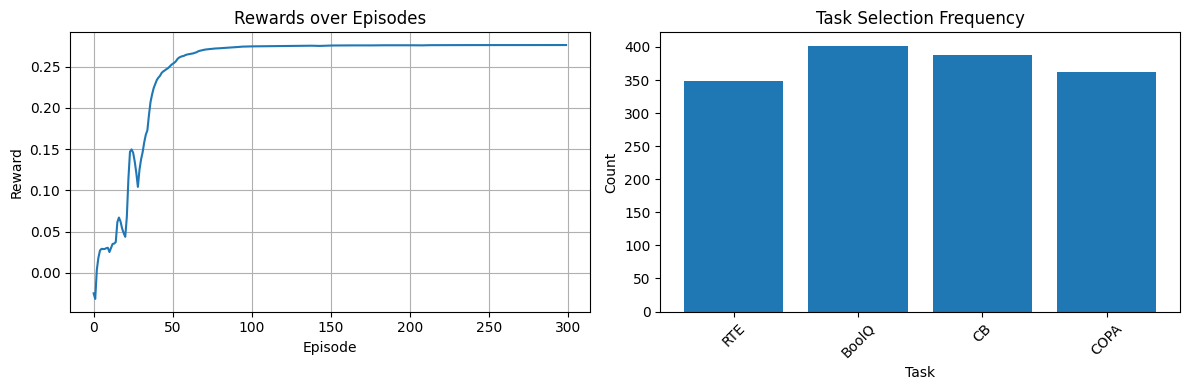

Average reward: 0.2487
Final reward: 0.2761


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if 'phase4' in history:
    # Plot rewards over episodes
    rewards = history['phase4']['rewards']

    plt.figure(figsize=(12, 4))

    # Reward curve
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)

    # Task distribution
    plt.subplot(1, 2, 2)
    trajectories = history['phase4']['trajectories']
    all_tasks = [task for traj in trajectories for task in traj]
    task_counts = {}
    for task in all_tasks:
        task_counts[task] = task_counts.get(task, 0) + 1

    plt.bar(task_counts.keys(), task_counts.values())
    plt.title('Task Selection Frequency')
    plt.xlabel('Task')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Average reward: {np.mean(rewards):.4f}")
    print(f"Final reward: {rewards[-1]:.4f}")

## 4. Weights & Biases Logging

In [ ]:
# Login to W&B (you'll need an account)
import wandb
wandb.login()

# Train with W&B logging
history = model.fit(
    train_loader=cb_loaders['train'],
    val_loader=cb_loaders['val'],
    wandb_logging=True,
    wandb_project='mpdistil-experiments',
    teacher_epochs=5,
    student_epochs=5
)

# View results at https://wandb.ai

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yashpatel02010 (yashpatel02010-nitk) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Validating DataLoaders...

Preparing task loaders...
Tasks: ['CB']
Label counts: {'cb': 3}

Initializing models...

Model Sizes:
  Teacher: 109,485,316 parameters
  Student: 66,958,084 parameters (61.2% of teacher)
  Action:  769 parameters

Starting MPDistil Training

=== Phase 1: Teacher Fine-tuning ===


Phase 1 Epoch 1/5: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, loss=1]


Epoch 1: Train Loss=1.1517, Val Metrics={'acc': 0.6428571428571429, 'val_loss': 0.9600460188729423, 'task': 'CB'}


Phase 1 Epoch 2/5: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s, loss=1.02]


Epoch 2: Train Loss=0.7589, Val Metrics={'acc': 0.6785714285714286, 'val_loss': 0.8138621534620013, 'task': 'CB'}


Phase 1 Epoch 3/5: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s, loss=0.712]


Epoch 3: Train Loss=0.6196, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.7987349544252668, 'task': 'CB'}


Phase 1 Epoch 4/5: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s, loss=0.288]


Epoch 4: Train Loss=0.4817, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7744543552398682, 'task': 'CB'}


Phase 1 Epoch 5/5: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s, loss=0.121]


Epoch 5: Train Loss=0.3100, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7374179448400225, 'task': 'CB'}

=== Phase 2: Student Knowledge Distillation ===


Phase 2 Epoch 1/5:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/5:  92%|█████████▏| 12/13 [00:03<00:00,  3.62it/s, total_loss=0.606, task_loss=0.658]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/5: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, total_loss=0.826, task_loss=1.1]


Epoch 1: Train Loss=0.7365, Task Loss=0.8938, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.8004148517336164, 'task': 'CB'}


Phase 2 Epoch 2/5:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 2/5:  92%|█████████▏| 12/13 [00:03<00:00,  3.63it/s, total_loss=0.794, task_loss=1.05]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 2/5: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s, total_loss=0.639, task_loss=0.747]


Epoch 2: Train Loss=0.6119, Task Loss=0.6846, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.772572032042912, 'task': 'CB'}


Phase 2 Epoch 3/5:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 3/5:  92%|█████████▏| 12/13 [00:03<00:00,  3.61it/s, total_loss=0.522, task_loss=0.51]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 3/5: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s, total_loss=0.494, task_loss=0.476]


Epoch 3: Train Loss=0.5623, Task Loss=0.5954, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.7629649128232684, 'task': 'CB'}


Phase 2 Epoch 4/5:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 4/5:  92%|█████████▏| 12/13 [00:03<00:00,  3.58it/s, total_loss=0.492, task_loss=0.447]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 4/5: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, total_loss=0.555, task_loss=0.601]


Epoch 4: Train Loss=0.4697, Task Loss=0.4191, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.8186254586492266, 'task': 'CB'}


Phase 2 Epoch 5/5:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 5/5:  92%|█████████▏| 12/13 [00:03<00:00,  3.61it/s, total_loss=0.387, task_loss=0.25]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 5/5: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, total_loss=0.372, task_loss=0.186]


Epoch 5: Train Loss=0.4280, Task Loss=0.3246, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.8161779982703072, 'task': 'CB'}

=== Phase 3: Meta-Teacher Learning ===


Phase 3: Meta-Teacher: 100%|██████████| 4/4 [00:00<00:00,  8.25it/s, meta_loss=0.307]


Phase 3: Meta Loss=0.6432, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.8918671182223729, 'task': 'CB'}

Training Complete!


## 5. Different Model Architectures

In [ ]:
# RoBERTa teacher → DistilBERT student
model_roberta = MPDistil(
    task_name='CB',
    num_labels=3,
    teacher_model='roberta-base',
    student_model='distilbert-base-uncased',
    student_layers=6
)

# Or BERT-large → BERT-base
model_large = MPDistil(
    task_name='CB',
    num_labels=3,
    teacher_model='bert-large-uncased',
    student_model='bert-base-uncased',
    student_layers=6
)

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## 6. Hyperparameter Tuning Tips

In [ ]:
# Quick hyperparameter search
alphas = [0.5, 0.7]
betas = [50, 100]

best_score = 0
best_params = {}

for alpha in alphas:
    for beta in betas:
        print(f"\nTrying alpha={alpha}, beta={beta}")

        model = MPDistil(task_name='CB', num_labels=3, student_layers=6)

        history = model.fit(
            train_loader=cb_loaders['train'],
            val_loader=cb_loaders['val'],
            teacher_epochs=1,
            student_epochs=1,
            alpha=alpha,
            beta=beta,
            num_episodes=0
        )

        # Get final score
        final_metrics = history['phase2']['val_metrics'][-1]
        score = final_metrics.get('acc', 0)

        print(f"Score: {score:.4f}")

        if score > best_score:
            best_score = score
            best_params = {'alpha': alpha, 'beta': beta}

print(f"\nBest params: {best_params}")
print(f"Best score: {best_score:.4f}")


Trying alpha=0.5, beta=50
Using device: cuda

Validating DataLoaders...

Preparing task loaders...
Tasks: ['CB']
Label counts: {'cb': 3}

Initializing models...

Model Sizes:
  Teacher: 109,485,316 parameters
  Student: 66,958,084 parameters (61.2% of teacher)
  Action:  769 parameters

Starting MPDistil Training

=== Phase 1: Teacher Fine-tuning ===


Phase 1 Epoch 1/1: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s, loss=1]


Epoch 1: Train Loss=1.1517, Val Metrics={'acc': 0.6428571428571429, 'val_loss': 0.9600460188729423, 'task': 'CB'}

=== Phase 2: Student Knowledge Distillation ===


Phase 2 Epoch 1/1:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/1:  92%|█████████▏| 12/13 [00:03<00:00,  3.62it/s, total_loss=0.557, task_loss=0.833]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/1: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, total_loss=0.698, task_loss=1.13]


Epoch 1: Train Loss=0.5894, Task Loss=0.8986, Val Metrics={'acc': 0.625, 'val_loss': 0.8152859210968018, 'task': 'CB'}

=== Phase 3: Meta-Teacher Learning ===


Phase 3: Meta-Teacher: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s, meta_loss=0.357]


Phase 3: Meta Loss=0.7450, Val Metrics={'acc': 0.625, 'val_loss': 1.0687051500592912, 'task': 'CB'}

Training Complete!
Score: 0.6250

Trying alpha=0.5, beta=100
Using device: cuda

Validating DataLoaders...

Preparing task loaders...
Tasks: ['CB']
Label counts: {'cb': 3}

Initializing models...

Model Sizes:
  Teacher: 109,485,316 parameters
  Student: 66,958,084 parameters (61.2% of teacher)
  Action:  769 parameters

Starting MPDistil Training

=== Phase 1: Teacher Fine-tuning ===


Phase 1 Epoch 1/1: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s, loss=1]


Epoch 1: Train Loss=1.1517, Val Metrics={'acc': 0.6428571428571429, 'val_loss': 0.9600460188729423, 'task': 'CB'}

=== Phase 2: Student Knowledge Distillation ===


Phase 2 Epoch 1/1:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/1:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=0.683, task_loss=0.836]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/1: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, total_loss=0.826, task_loss=1.14]


Epoch 1: Train Loss=0.7160, Task Loss=0.9002, Val Metrics={'acc': 0.6428571428571429, 'val_loss': 0.8173977988106864, 'task': 'CB'}

=== Phase 3: Meta-Teacher Learning ===


Phase 3: Meta-Teacher: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s, meta_loss=0.366]


Phase 3: Meta Loss=0.7448, Val Metrics={'acc': 0.6071428571428571, 'val_loss': 1.0654751573290144, 'task': 'CB'}

Training Complete!
Score: 0.6429

Trying alpha=0.7, beta=50
Using device: cuda

Validating DataLoaders...

Preparing task loaders...
Tasks: ['CB']
Label counts: {'cb': 3}

Initializing models...

Model Sizes:
  Teacher: 109,485,316 parameters
  Student: 66,958,084 parameters (61.2% of teacher)
  Action:  769 parameters

Starting MPDistil Training

=== Phase 1: Teacher Fine-tuning ===


Phase 1 Epoch 1/1: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s, loss=1]


Epoch 1: Train Loss=1.1517, Val Metrics={'acc': 0.6428571428571429, 'val_loss': 0.9600460188729423, 'task': 'CB'}

=== Phase 2: Student Knowledge Distillation ===


Phase 2 Epoch 1/1:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/1:  92%|█████████▏| 12/13 [00:03<00:00,  3.58it/s, total_loss=0.393, task_loss=0.84]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/1: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s, total_loss=0.463, task_loss=1.1]


Epoch 1: Train Loss=0.4137, Task Loss=0.9050, Val Metrics={'acc': 0.6785714285714286, 'val_loss': 0.8258909157344273, 'task': 'CB'}

=== Phase 3: Meta-Teacher Learning ===


Phase 3: Meta-Teacher: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s, meta_loss=0.363]


Phase 3: Meta Loss=0.7434, Val Metrics={'acc': 0.6071428571428571, 'val_loss': 1.0642074601990836, 'task': 'CB'}

Training Complete!
Score: 0.6786

Trying alpha=0.7, beta=100
Using device: cuda

Validating DataLoaders...

Preparing task loaders...
Tasks: ['CB']
Label counts: {'cb': 3}

Initializing models...

Model Sizes:
  Teacher: 109,485,316 parameters
  Student: 66,958,084 parameters (61.2% of teacher)
  Action:  769 parameters

Starting MPDistil Training

=== Phase 1: Teacher Fine-tuning ===


Phase 1 Epoch 1/1: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s, loss=1]


Epoch 1: Train Loss=1.1517, Val Metrics={'acc': 0.6428571428571429, 'val_loss': 0.9600460188729423, 'task': 'CB'}

=== Phase 2: Student Knowledge Distillation ===


Phase 2 Epoch 1/1:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/1:  92%|█████████▏| 12/13 [00:03<00:00,  3.60it/s, total_loss=0.515, task_loss=0.844]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/1: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s, total_loss=0.585, task_loss=1.1]


Epoch 1: Train Loss=0.5392, Task Loss=0.9081, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.8302101407732282, 'task': 'CB'}

=== Phase 3: Meta-Teacher Learning ===


Phase 3: Meta-Teacher: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s, meta_loss=0.364]


Phase 3: Meta Loss=0.7378, Val Metrics={'acc': 0.6071428571428571, 'val_loss': 1.06476206438882, 'task': 'CB'}

Training Complete!
Score: 0.6964

Best params: {'alpha': 0.7, 'beta': 100}
Best score: 0.6964


## 7. Checkpoint Resumption

In [ ]:
# Save model state during training
config_resume = TrainingConfig(
    output_dir='./checkpoints',
    save_checkpoints=True,
    teacher_epochs=10,
    student_epochs=10
)

# Train (will save checkpoints)
history = model.fit(
    train_loader=cb_loaders['train'],
    val_loader=cb_loaders['val'],
    config=config_resume
)

# Later, load best checkpoint
# Note: Currently loads automatically at end of each phase


Validating DataLoaders...

Preparing task loaders...
Tasks: ['CB']
Label counts: {'cb': 3}

Initializing models...

Model Sizes:
  Teacher: 109,485,316 parameters
  Student: 66,958,084 parameters (61.2% of teacher)
  Action:  769 parameters

Starting MPDistil Training

=== Phase 1: Teacher Fine-tuning ===


Phase 1 Epoch 1/10: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s, loss=1]


Epoch 1: Train Loss=1.1517, Val Metrics={'acc': 0.6428571428571429, 'val_loss': 0.9600460188729423, 'task': 'CB'}


Phase 1 Epoch 2/10: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s, loss=1.02]


Epoch 2: Train Loss=0.7589, Val Metrics={'acc': 0.6785714285714286, 'val_loss': 0.8138621534620013, 'task': 'CB'}


Phase 1 Epoch 3/10: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s, loss=0.712]


Epoch 3: Train Loss=0.6196, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.7987349544252668, 'task': 'CB'}


Phase 1 Epoch 4/10: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s, loss=0.288]


Epoch 4: Train Loss=0.4817, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7744543552398682, 'task': 'CB'}


Phase 1 Epoch 5/10: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s, loss=0.121]


Epoch 5: Train Loss=0.3100, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7374179448400225, 'task': 'CB'}


Phase 1 Epoch 6/10: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s, loss=0.519]


Epoch 6: Train Loss=0.2198, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 0.7974880422864642, 'task': 'CB'}


Phase 1 Epoch 7/10: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s, loss=0.207]


Epoch 7: Train Loss=0.1488, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.9981529419975621, 'task': 'CB'}


Phase 1 Epoch 8/10: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s, loss=0.0338]


Epoch 8: Train Loss=0.1082, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 0.97016955273492, 'task': 'CB'}


Phase 1 Epoch 9/10: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, loss=0.0126]


Epoch 9: Train Loss=0.0800, Val Metrics={'acc': 0.75, 'val_loss': 0.9345694950648716, 'task': 'CB'}


Phase 1 Epoch 10/10: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s, loss=0.0562]


Epoch 10: Train Loss=0.0676, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.9652910232543945, 'task': 'CB'}

=== Phase 2: Student Knowledge Distillation ===


Phase 2 Epoch 1/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=1.03, task_loss=0.924]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 1/10: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, total_loss=0.933, task_loss=0.647]


Epoch 1: Train Loss=1.0465, Task Loss=0.8645, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.795985392161778, 'task': 'CB'}


Phase 2 Epoch 2/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 2/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.59it/s, total_loss=0.782, task_loss=0.506]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 2/10: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s, total_loss=0.825, task_loss=0.702]


Epoch 2: Train Loss=0.8944, Task Loss=0.6962, Val Metrics={'acc': 0.6964285714285714, 'val_loss': 0.7889728546142578, 'task': 'CB'}


Phase 2 Epoch 3/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 3/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.58it/s, total_loss=0.931, task_loss=0.852]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 3/10: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, total_loss=0.648, task_loss=0.455]


Epoch 3: Train Loss=0.7650, Task Loss=0.5768, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 0.8348208495548793, 'task': 'CB'}


Phase 2 Epoch 4/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 4/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.58it/s, total_loss=0.431, task_loss=0.119]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 4/10: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s, total_loss=0.786, task_loss=0.889]


Epoch 4: Train Loss=0.6151, Task Loss=0.4261, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 0.9362039608614785, 'task': 'CB'}


Phase 2 Epoch 5/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 5/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.56it/s, total_loss=0.54, task_loss=0.381]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 5/10: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, total_loss=0.348, task_loss=0.0718]


Epoch 5: Train Loss=0.4960, Task Loss=0.3086, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 1.0992927210671561, 'task': 'CB'}


Phase 2 Epoch 6/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 6/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=0.277, task_loss=0.0263]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 6/10: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, total_loss=0.3, task_loss=0.0503]


Epoch 6: Train Loss=0.4021, Task Loss=0.2193, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 1.2570016043526786, 'task': 'CB'}


Phase 2 Epoch 7/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 7/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=0.363, task_loss=0.197]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 7/10: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, total_loss=0.662, task_loss=0.785]


Epoch 7: Train Loss=0.3498, Task Loss=0.1763, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 1.3684610639299666, 'task': 'CB'}


Phase 2 Epoch 8/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 8/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.53it/s, total_loss=0.271, task_loss=0.0762]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 8/10: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, total_loss=0.26, task_loss=0.0578]


Epoch 8: Train Loss=0.2938, Task Loss=0.1032, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 1.2767046689987183, 'task': 'CB'}


Phase 2 Epoch 9/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 9/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.57it/s, total_loss=0.262, task_loss=0.0418]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 9/10: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s, total_loss=0.262, task_loss=0.0582]


Epoch 9: Train Loss=0.2743, Task Loss=0.0829, Val Metrics={'acc': 0.7142857142857143, 'val_loss': 1.32099107333592, 'task': 'CB'}


Phase 2 Epoch 10/10:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([11, 16, 768])) that is different to the input size (torch.Size([16, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 10/10:  92%|█████████▏| 12/13 [00:03<00:00,  3.54it/s, total_loss=0.207, task_loss=0.00816]/usr/local/lib/python3.12/dist-packages/mpdistil/trainer.py:371: UserWarning: Using a target size (torch.Size([8, 8, 768])) that is different to the input size (torch.Size([8, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pkd_loss = F.mse_loss(s_features, t_features, reduction="mean")
Phase 2 Epoch 10/10: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, total_loss=0.205, task_loss=0.00775]


Epoch 10: Train Loss=0.2438, Task Loss=0.0493, Val Metrics={'acc': 0.7321428571428571, 'val_loss': 1.325568437576294, 'task': 'CB'}

=== Phase 3: Meta-Teacher Learning ===


Phase 3: Meta-Teacher: 100%|██████████| 4/4 [00:00<00:00,  8.10it/s, meta_loss=0.976]


Phase 3: Meta Loss=0.6926, Val Metrics={'acc': 0.75, 'val_loss': 0.9949109554290771, 'task': 'CB'}

Training Complete!
